In [1]:
import pandas as pd

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from backtesting import Backtest

In [4]:
%matplotlib inline
import seaborn as sns
from Price_Data import hist_data

In [5]:
import matplotlib.pyplot as plt

In [6]:
btcusd = hist_data('Bitstamp')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
btcusd.columns = ['Open']

In [8]:
ss = btcusd.resample('H')

In [9]:
op = ss.first().ffill()
hi = ss.max().ffill()
lo = ss.min().ffill()
cl = ss.last().ffill()

In [10]:
btcusd

,Open
Date,
2011-09-13 13:53:36,5.80
2011-09-13 13:53:44,5.83
2011-09-13 13:53:49,5.90
2011-09-13 13:53:54,6.00
2011-09-13 14:32:53,5.95
...,...
2019-12-12 23:58:18,7184.44
2019-12-12 23:58:20,7184.44
2019-12-12 23:59:05,7190.53


In [11]:
ohlc = op
ohlc.columns = ['Open']
ohlc['High'] = hi
ohlc['Low'] = lo
ohlc['Close'] = cl
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-13 13:00:00,5.80,6.00,5.80,6.00
2011-09-13 14:00:00,5.95,5.95,5.76,5.76
2011-09-13 15:00:00,5.65,5.65,5.65,5.65
2011-09-13 16:00:00,5.65,5.65,5.65,5.65
2011-09-13 17:00:00,5.65,5.65,5.65,5.65
...,...,...,...,...
2019-12-12 19:00:00,7205.66,7218.00,7186.36,7193.66
2019-12-12 20:00:00,7205.14,7250.23,7195.00,7242.49
2019-12-12 21:00:00,7245.85,7253.68,7180.83,7194.57


In [12]:
import datetime as dt

In [13]:
final = ohlc.index[-1]
final

Timestamp('2019-12-12 23:00:00', freq='H')

In [14]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# 1 Year SMA and EMA

In [25]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [26]:
class SmaCross(Strategy):
    
    n1 = 100
    n2 = 1000
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [27]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [28]:
class EmaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [29]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [30]:
class DemaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

In [31]:
import scipy.interpolate as interp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Strategies for different Time Horizons

In [32]:
def time_horiz(hist,ma):
    
    if ma == 'SMA':
        bt = Backtest(hist,SmaCross,cash=10000)
    elif ma == 'EMA':
        bt = Backtest(hist,EmaCross,cash=10000)
    elif ma == 'DEMA':
        bt = Backtest(hist,DemaCross,cash=10000)
    
    data, heat = bt.optimize('Sharpe Ratio',n1=range(1,200,9),n2=range(1,200,9),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

    heat.sort_values()
    hmap = heat.groupby(['n1','n2']).mean().unstack()
    hmap

    heat_pic = sns.heatmap(hmap, cmap='Spectral')
    
    tr = hmap.stack()

    n1 = [i[0] for i in tr.index]
    n2 = [i[1] for i in tr.index]

    val = []
    for (i,j) in zip(n1,n2):
        if i<j:
            val.append(tr.loc[i,j])

    px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),100),np.linspace(np.min(n2),np.max(n2),100))
    pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(px,py,pz,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    return data

# 1 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


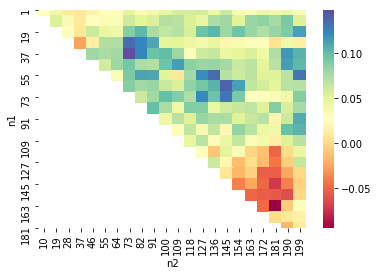

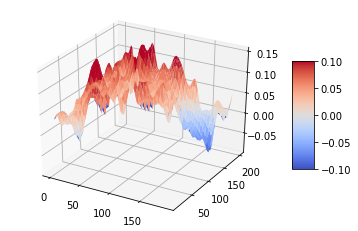

Start                       2018-12-12 00:00:00
End                         2019-12-12 23:00:00
Duration                      365 days 23:00:00
Exposure [%]                            97.6318
Equity Final [$]                        27938.3
Equity Peak [$]                           28153
Return [%]                              179.383
Buy & Hold Return [%]                   115.559
Max. Drawdown [%]                      -36.0934
Avg. Drawdown [%]                      -4.24022
Max. Drawdown Duration        103 days 08:00:00
Avg. Drawdown Duration          6 days 02:00:00
# Trades                                    137
Win Rate [%]                            42.3358
Best Trade [%]                          26.2978
Worst Trade [%]                        -9.69474
Avg. Trade [%]                         0.888667
Max. Trade Duration             9 days 20:00:00
Avg. Trade Duration             2 days 15:00:00
Expectancy [%]                          3.46709
SQN                                     

In [34]:
time_horiz(yr1,'SMA')

# 1 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


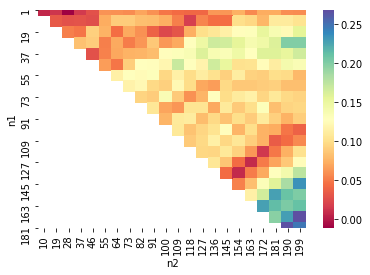

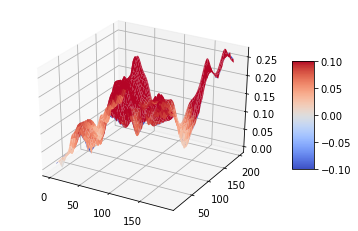

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                              98.5313
Equity Final [$]                          20039.8
Equity Peak [$]                             29332
Return [%]                                100.398
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                        -42.2407
Avg. Drawdown [%]                        -3.62059
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            5 days 23:00:00
# Trades                                       22
Win Rate [%]                              40.9091
Best Trade [%]                            44.7955
Worst Trade [%]                          -16.4162
Avg. Trade [%]                            4.00617
Max. Trade Duration              52 days 00:00:00
Avg. Trade Duration              16 days 10:00:00
Expectancy [%]                            9.78348


In [35]:
time_horiz(yr1,'EMA')

# 1 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


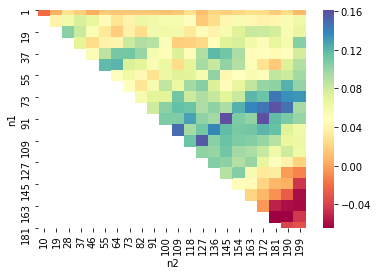

C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


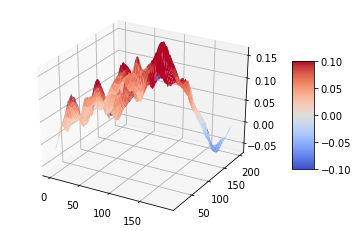

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                               98.759
Equity Final [$]                          21746.3
Equity Peak [$]                           24759.8
Return [%]                                117.463
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                         -39.166
Avg. Drawdown [%]                        -4.04884
Max. Drawdown Duration          151 days 10:00:00
Avg. Drawdown Duration            6 days 01:00:00
# Trades                                       62
Win Rate [%]                              40.3226
Best Trade [%]                            44.0241
Worst Trade [%]                          -19.8067
Avg. Trade [%]                            1.72435
Max. Trade Duration              18 days 09:00:00
Avg. Trade Duration               5 days 20:00:00
Expectancy [%]                            6.40105


In [33]:
time_horiz(yr1,'DEMA')

# 2 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


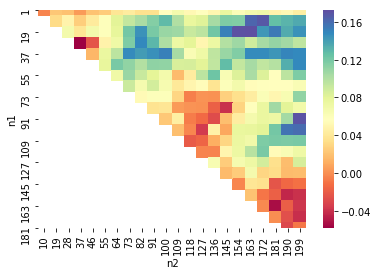

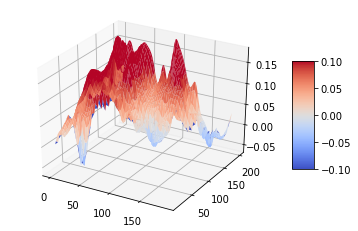

Start                        2017-12-12 00:00:00
End                          2019-12-12 23:00:00
Duration                       730 days 23:00:00
Exposure [%]                             98.5179
Equity Final [$]                         57571.9
Equity Peak [$]                          65793.7
Return [%]                               475.719
Buy & Hold Return [%]                     56.235
Max. Drawdown [%]                       -38.3837
Avg. Drawdown [%]                       -3.91674
Max. Drawdown Duration         138 days 12:00:00
Avg. Drawdown Duration           4 days 23:00:00
# Trades                                     150
Win Rate [%]                                  36
Best Trade [%]                           39.7427
Worst Trade [%]                         -13.3247
Avg. Trade [%]                           1.47945
Max. Trade Duration             20 days 06:00:00
Avg. Trade Duration              4 days 20:00:00
Expectancy [%]                           5.01762
SQN                 

In [36]:
time_horiz(yr2,'SMA')

# 2 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


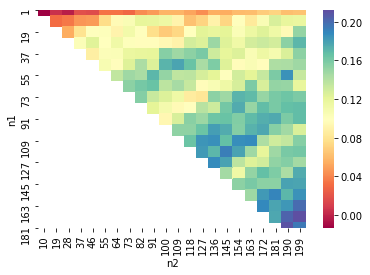

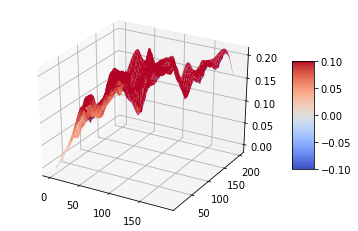

Start                         2017-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        730 days 23:00:00
Exposure [%]                              99.5839
Equity Final [$]                          30380.9
Equity Peak [$]                           44468.3
Return [%]                                203.809
Buy & Hold Return [%]                      56.235
Max. Drawdown [%]                        -42.2407
Avg. Drawdown [%]                        -3.85208
Max. Drawdown Duration          209 days 16:00:00
Avg. Drawdown Duration            6 days 07:00:00
# Trades                                       54
Win Rate [%]                              31.4815
Best Trade [%]                            44.7955
Worst Trade [%]                          -16.4162
Avg. Trade [%]                            2.74494
Max. Trade Duration              52 days 00:00:00
Avg. Trade Duration              13 days 12:00:00
Expectancy [%]                            8.35826


In [37]:
time_horiz(yr2,'EMA')

# 2 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


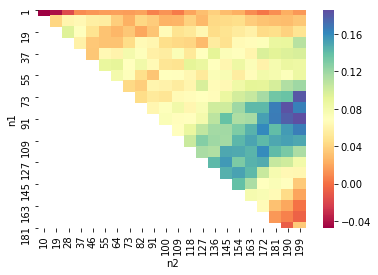

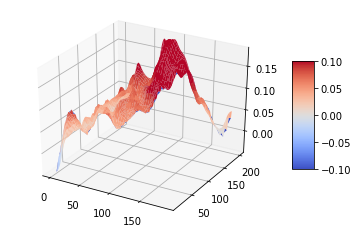

Start                         2017-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        730 days 23:00:00
Exposure [%]                              99.6751
Equity Final [$]                          53446.5
Equity Peak [$]                           58302.7
Return [%]                                434.465
Buy & Hold Return [%]                      56.235
Max. Drawdown [%]                        -40.9096
Avg. Drawdown [%]                        -4.26842
Max. Drawdown Duration          155 days 18:00:00
Avg. Drawdown Duration            5 days 11:00:00
# Trades                                      114
Win Rate [%]                              35.9649
Best Trade [%]                            41.2899
Worst Trade [%]                          -23.6758
Avg. Trade [%]                            1.98283
Max. Trade Duration              26 days 11:00:00
Avg. Trade Duration               6 days 10:00:00
Expectancy [%]                            6.82322


In [38]:
time_horiz(yr2,'DEMA')

# 4 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


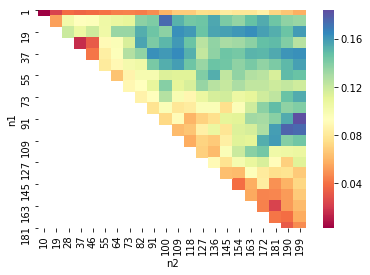

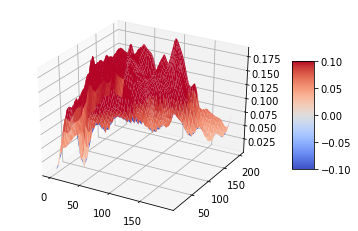

Start                        2015-12-12 00:00:00
End                          2019-12-12 23:00:00
Duration                      1461 days 23:00:00
Exposure [%]                             99.2276
Equity Final [$]                          245261
Equity Peak [$]                           446508
Return [%]                               2352.61
Buy & Hold Return [%]                    1480.12
Max. Drawdown [%]                       -55.6583
Avg. Drawdown [%]                       -4.18043
Max. Drawdown Duration         195 days 04:00:00
Avg. Drawdown Duration           5 days 12:00:00
# Trades                                     188
Win Rate [%]                              37.766
Best Trade [%]                           97.4489
Worst Trade [%]                         -23.0391
Avg. Trade [%]                           2.37627
Max. Trade Duration             37 days 07:00:00
Avg. Trade Duration              7 days 18:00:00
Expectancy [%]                            6.9487
SQN                 

In [39]:
time_horiz(yr4,'SMA')

# 4 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


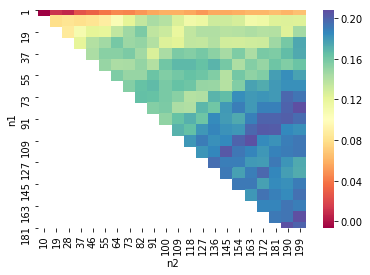

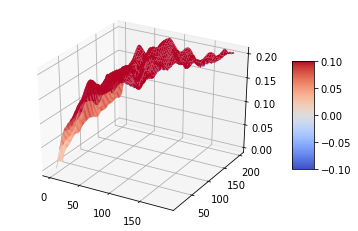

Start                         2015-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                       1461 days 23:00:00
Exposure [%]                              99.7891
Equity Final [$]                           117528
Equity Peak [$]                            172025
Return [%]                                1075.28
Buy & Hold Return [%]                     1480.12
Max. Drawdown [%]                        -66.9487
Avg. Drawdown [%]                         -4.5158
Max. Drawdown Duration          252 days 00:00:00
Avg. Drawdown Duration            8 days 07:00:00
# Trades                                       96
Win Rate [%]                               34.375
Best Trade [%]                             94.384
Worst Trade [%]                          -28.9035
Avg. Trade [%]                            3.91981
Max. Trade Duration              75 days 01:00:00
Avg. Trade Duration              15 days 05:00:00
Expectancy [%]                            10.8537


In [40]:
time_horiz(yr4,'EMA')

# 4 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


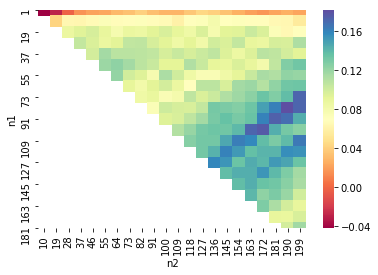

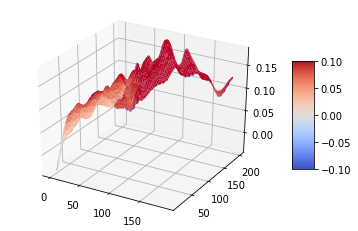

Start                         2015-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                       1461 days 23:00:00
Exposure [%]                              99.8261
Equity Final [$]                           318107
Equity Peak [$]                            368707
Return [%]                                3081.07
Buy & Hold Return [%]                     1480.12
Max. Drawdown [%]                        -54.9717
Avg. Drawdown [%]                        -4.09881
Max. Drawdown Duration          168 days 15:00:00
Avg. Drawdown Duration            5 days 11:00:00
# Trades                                      262
Win Rate [%]                              38.5496
Best Trade [%]                            44.1492
Worst Trade [%]                          -22.8061
Avg. Trade [%]                            1.74535
Max. Trade Duration              26 days 10:00:00
Avg. Trade Duration               5 days 14:00:00
Expectancy [%]                            6.28929


In [41]:
time_horiz(yr4,'DEMA')